# Force Perturbation Dataset: Preprocessing and Baseline Decoder Analysis

## Overview

This notebook is dedicated to the preprocessing, analysis, and baseline model development for the Force Perturbation center-out (CO) task dataset. The primary objectives are to preprocess the neural and kinematic data, apply transformations, and develop baseline decoders to understand the neural encoding of movement in the context of force perturbations.

## Notebook Structure

1. **Data Loading and Initial Exploration**: We begin by loading the data from a `.mat` file into a DataFrame, followed by an initial exploration of the neural and kinematic data.

2. **Preprocessing Pipeline**:
    - **Time Bin Adjustment**: Time bins are combined to form 20ms windows, which is the standard used in our analysis for computing firing rates and velocities.
    - **Neuron Filtering**: Low-firing neurons are removed based on a threshold to ensure that only neurons with significant activity are included in the analysis.
    - **Signal Transformation**: A square root transformation is applied to the neural signals to stabilize variance and normalize the data distribution.
    - **Signal Merging**: Signals from the motor and pre-motor cortex are merged into a single variable, reflecting the integrated functional role of these regions.
    - **Firing Rate Computation**: Firing rates are computed using a Gaussian window, with different standard deviations to explore their impact on the decoders' performance.
    - **Trial Selection and Length Adjustment**: Only rewarded trials are retained, and trial lengths are standardized based on movement-related events.

3. **Data Augmentation**: To account for temporal dependencies in neural activity, the data is augmented by creating additional time-shifted versions of the spike rates.

4. **Baseline Model Development**:
    - **Train-Test Split**: The baseline dataset (without force perturbation) is split into training, validation, and test sets.
    - **Linear Decoder**: A Ridge regression model is trained on the baseline data to establish a linear decoding benchmark.
    - **Non-linear Decoder (LSTM)**: An LSTM-based model is developed to capture the non-linear relationships in the neural data, with a comparison to the linear baseline.

5. **Model Evaluation and Visualization**: The performance of both linear and non-linear models is evaluated, with results visualized to compare the effectiveness of each approach.

## Purpose

This notebook serves as a foundation for analyzing the Force Perturbation dataset. The preprocessing steps ensure that the data is clean and standardized, while the baseline decoders provide a reference point for future model improvements, particularly in the context of continual learning and adaptive neural decoding.


### First imports

In [1]:
### Imports

import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Navigate up two levels to reach the grandparent directory (CL Control)
parent_dir = os.path.abspath(os.path.join('..',))
sys.path.append(parent_dir)

from src.helpers import *
from sklearn.metrics import *
from Models.models import *
import pickle
import math

import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

from pyaldata import *

from src.visualize import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Chewie_CO_FF_2016-10-07.mat")
name = 'Chewie'
date = '1007'
path_to_save_data = os.path.join(data_dir, 'Processed_Data', 'Tidy_'+name+'_'+str(date)+'.pkl')

In [3]:
# Load TrialData .mat file into a DataFrame
df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

### Start preprocessing

a) For now combining bins to have 20ms instead of 10ms long windows to compute firing rate and velocity. We will see later if it should be done or not but we leave it as it may affect the thresholds for low-firing neurons and other functions.

In [4]:
# Combine time-bins into longer ones
td = combine_time_bins(df, 2)

b) Remove low-firing neurons. This function uses a threshold which is in Hz. 
As the threshold is 5Hz, that means that in 20ms bin we need at least 1 spike.
The function removes all neurons with an average firing rate below the threshold.

`Note` I am not sure if the threshold should be adjusted. With this threshold we remove 23/70 neurons ( so 33% ), whereas in the other dataset it was only 4/64. 

In [5]:
# Remove low-firing neurons
td = remove_low_firing_neurons(td, "M1_spikes",  5, divide_by_bin_size=True, verbose=True)
td = remove_low_firing_neurons(td, "PMd_spikes", 5, divide_by_bin_size=True, verbose=True)
print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

Removed 23 neurons from M1_spikes.
Removed 54 neurons from PMd_spikes.
original:  (359, 70)
removed:   (179, 47)


c) Transform signals to get the SQRT

In [6]:
# Transform signals
td_2 = transform_signal(td, "M1_spikes",  'sqrt')
td_2 = transform_signal(td_2, "PMd_spikes", 'sqrt')

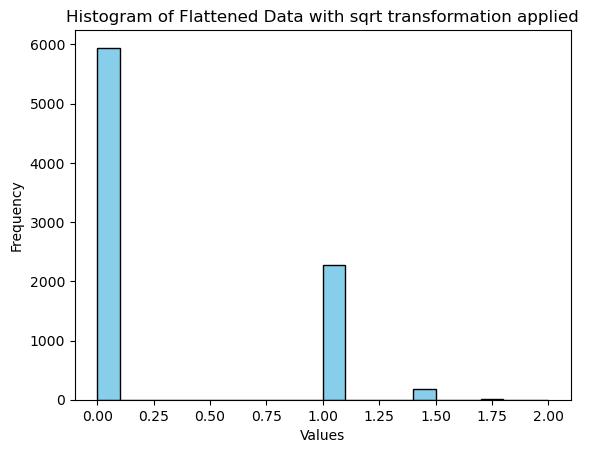

Mean :  0.304  Variance :  0.226


In [7]:
flattened_data_td2 = td_2.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data_td2, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data with sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data_td2.mean(), 3), ' Variance : ', np.round(flattened_data_td2.var(), 3))

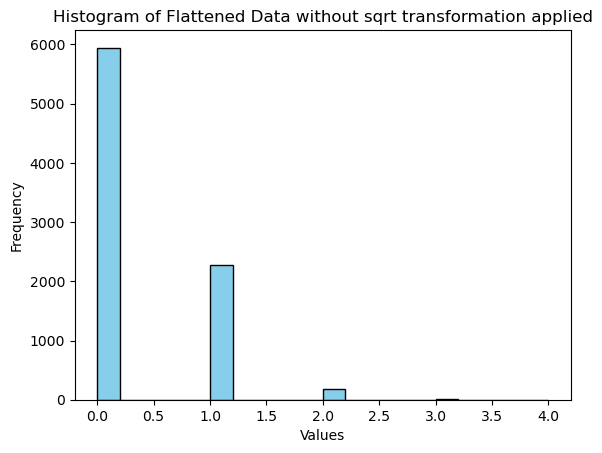

Mean :  0.318  Variance :  0.271


In [8]:
flattened_data = td.M1_spikes[0].flatten()

# Plot histogram
plt.hist(flattened_data, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Flattened Data without sqrt transformation applied')

# Show plot
plt.show()
print('Mean : ' ,np.round(flattened_data.mean(), 3), ' Variance : ', np.round(flattened_data.var(), 3))

Overall, while the square root transformation is not always necessary or appropriate, it can be a valuable preprocessing step for neural data analysis, helping to address issues related to variance stabilization, linearity, and normalization.

d) Merge signals

Signals from the pre-motor and motor cortex are now combines in one same variable,  we do not consider the 2 regions as different but more as functionally working together.


In [9]:
td = merge_signals(td_2, ["M1_spikes", "PMd_spikes"], "both_spikes")

e) Compute firing rates. 

The way this is done is:
- First the std is defined or computed (the default value is 0.05)
- Then the std and the bin size are used to compute the gaussian window
- This window is used to compute a 1d convolution with each train of spikes and hence smooth and compute the firing rates per neuron.

To understand the effect of the window size in the models performances we will compute the firing rates twice, using different std.

In [10]:
# Compute firing rates standard mode
td = add_firing_rates(td, 'smooth', std = 0.05)
td_2 = add_firing_rates(td, 'smooth', std = 0.025)

# Add the variable with the thinner gaussian window to compute the firing rates.
td['both_rates_2'] = td_2['both_rates']  

f) Keep only rewarded trials

In [11]:
td = td.loc[td.result == 'R'].reset_index()

g) Trial length: how to find windows of the same length for the trials?

First idea: check the peak velocity and take values around this point

In [12]:
trial_lengths = [td.vel[i].shape[0] for i in range(len(td.vel))]

In [13]:
min_l = np.min(trial_lengths)
max_l = np.max(trial_lengths)
print('Minimum trial length: ', min_l, ' Maximum trial length : ', max_l)

Minimum trial length:  137  Maximum trial length :  588


In [14]:
indices = [index for index, value in enumerate(trial_lengths) if value < 175]
len(indices)

110

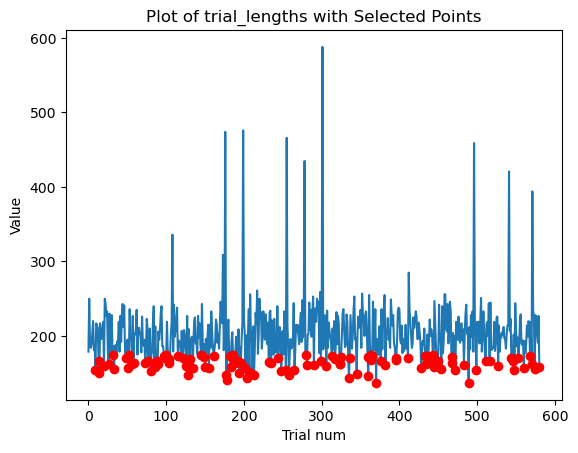

In [15]:
import matplotlib.pyplot as plt

# Plotting trial_lengths
plt.plot(trial_lengths)

# Plotting specific points using indices
plt.plot(indices, [trial_lengths[i] for i in indices], 'ro')  # 'ro' plots red circles

plt.xlabel('Trial num')
plt.ylabel('Value')
plt.title('Plot of trial_lengths with Selected Points')
plt.show()


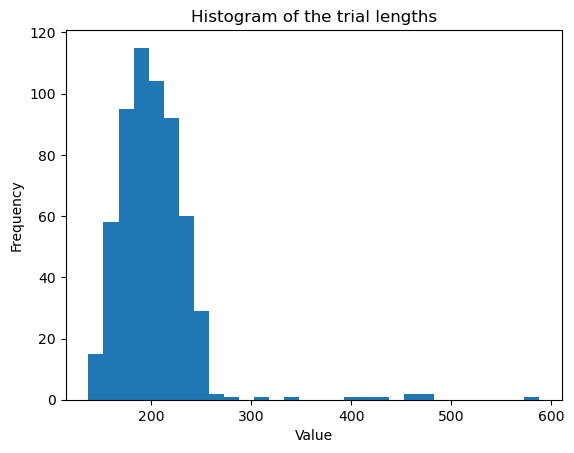

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
data = trial_lengths

# Compute the histogram
hist, bins = np.histogram(data, bins=30)

# Plotting the histogram
plt.hist(data, bins=bins)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the trial lengths')
plt.show()

53


Text(0.5, 1.0, 'Trial split for the different parts of the movement')

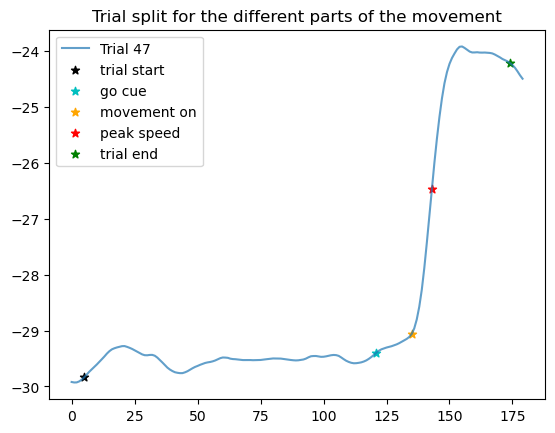

In [17]:
trial_num = 47

plt.plot(td.pos[trial_num][:,1], label = 'Trial ' + str(trial_num), alpha = 0.7)
plt.scatter(td.idx_trial_start[trial_num],td.pos[trial_num][td.idx_trial_start[trial_num],1] , c = 'k', marker= '*', label = 'trial start')
plt.scatter(td.idx_go_cue[trial_num],td.pos[trial_num][td.idx_go_cue[trial_num],1] , c = 'c', marker= '*', label = 'go cue')
plt.scatter(td.idx_movement_on[trial_num],td.pos[trial_num][td.idx_movement_on[trial_num],1] , c = 'orange', marker= '*', label = 'movement on')
plt.scatter(td.idx_peak_speed[trial_num],td.pos[trial_num][td.idx_peak_speed[trial_num],1] , c = 'r', marker= '*', label = 'peak speed')
plt.scatter(td.idx_trial_end[trial_num],td.pos[trial_num][td.idx_trial_end[trial_num],1] , c = 'g', marker= '*', label = 'trial end')
plt.legend()
print(td.idx_trial_end[trial_num] - td.idx_go_cue[trial_num])
plt.title('Trial split for the different parts of the movement')

Most of the movement of interest is between the go cue and the end of the trial. We need to make sure that the distance between those two is not too different from trial to trial and check the maximum distance so we can take the last part of the trials using this value.

In [18]:
dur_trial = [td.idx_trial_end[i] - td.idx_go_cue[i] for i in range(len(td))]
np.max(dur_trial)

75

There is no trial with a distance bigger than 75 samples, so we can say we use the last 100 samples from each trial and we should be able to get all necessary data.

In [19]:
variables_to_cut = ['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']
for i in variables_to_cut:
    td[i] = td[i].apply(lambda x: x[-100:])

Now we want to concatenate all trials one after the other.

In [20]:
td = td.explode(['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates', 'both_rates_2']).reset_index()

In [21]:
td.loc[td.trial_id == 5][['trial_id', 'pos', 'vel']].head(3)

,trial_id,pos,vel
200,5,"[0.17819852235245115, -30.055449847498167]","[0.858193349977317, 0.9150490725092748]"
201,5,"[0.1998603841915525, -30.03645001503957]","[1.2472336587016735, 0.8915203018606699]"
202,5,"[0.22581833701365284, -30.019478346993672]","[1.1917484688647204, 0.8710352080699665]"


### Data augmentation for linear decoders

Data augmentation to account for the neural activity up to 100ms before the position/movement. 
We build 5 new timeseries, each one starting 20ms after. We pad the data using the first sample.

In [22]:
tidy_df = td.copy()

In [23]:
tidy_df['both_rates1'] = pd.concat([tidy_df.both_rates[:1], tidy_df.both_rates[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates2'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates3'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1],tidy_df.both_rates[:1],  tidy_df.both_rates[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates4'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates5'] = pd.concat([tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1],tidy_df.both_rates[:1], tidy_df.both_rates[:1], tidy_df.both_rates[:-5]]).reset_index().drop(columns = 'index')

In [24]:
tidy_df['both_rates_21'] = pd.concat([tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-1]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_22'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-2]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_23'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1],  tidy_df.both_rates_2[:-3]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_24'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-4]]).reset_index().drop(columns = 'index')
tidy_df['both_rates_25'] = pd.concat([tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1],tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:1], tidy_df.both_rates_2[:-5]]).reset_index().drop(columns = 'index')

In [25]:
def extend_cols(x, main_col, cols):
    data = x[main_col]
    for c in cols:
        data = np.concatenate([data, x[c]])
    return data

In [26]:
tidy_df['both_rates_augmented'] = tidy_df[['both_rates', 'both_rates1', 
                                      'both_rates2', 'both_rates3', 
                                      'both_rates4', 'both_rates5']].apply(lambda x: extend_cols(x, 'both_rates', 
                                                                                                   ['both_rates1', 'both_rates2', 
                                                                                                    'both_rates3', 'both_rates4', 
                                                                                                    'both_rates5']), axis = 1)

In [27]:
tidy_df['both_rates_augmented_2'] = tidy_df[['both_rates_2', 'both_rates_21', 
                                      'both_rates_22', 'both_rates_23', 
                                      'both_rates_24', 'both_rates_25']].apply(lambda x: extend_cols(x, 'both_rates_2', 
                                                                                                   ['both_rates_21', 'both_rates_22', 
                                                                                                    'both_rates_23', 'both_rates_24', 
                                                                                                    'both_rates_25']), axis = 1)

In [28]:
tidy_df.rename(columns={'trial_id': 'id'}, inplace=True)

In [29]:
with open(path_to_save_data, 'wb') as handle:
            pickle.dump(tidy_df, handle, protocol=4)

## Baseline Models

First, we will go for models of the baseline trials, that is the trials for which there is not a force perturbation.

In [30]:
tidy_df.epoch.unique()

array(['BL', 'AD', 'WO'], dtype=object)

In [31]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

### Train-Test split

In [32]:
X_train, y_train, X_val, y_val, X_test,\
      y_test, info_train, info_val,\
          info_test, mins, maxs = train_test_split(baseline_df,\
                                                    train_variable = 'both_rates_augmented', 
                                                    target_variable = 'vel', num_folds = 5)

## Linear Decoder

In [33]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

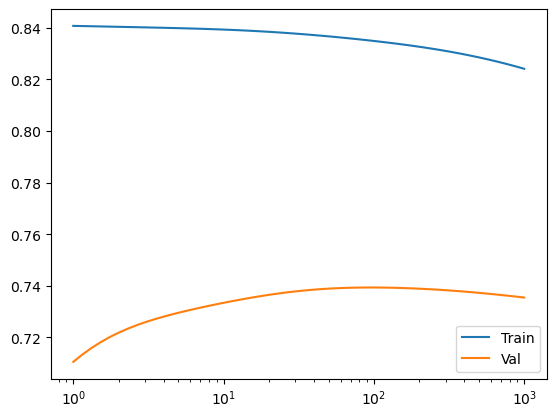

In [34]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(0, 3, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 1:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [35]:
best_a

[79.06043210907697,
 91.02981779915218,
 212.09508879201903,
 138.94954943731372,
 281.1768697974231]

In [36]:
np.mean(test_score)

0.7623658353483883

In [37]:
np.mean(train_score)

0.8321771907842429

I have used both the features computed with the thinner gaussian window and the ones with the default (0.05 std), and the results are better with the default one.

#### Now running the model with the best alpha

In [38]:
fold = 0
model = Ridge(alpha = best_a[fold], fit_intercept=True)
model.fit(X_train['fold'+str(fold)], y_train['fold'+str(fold)])

Ridge(alpha=79.06043210907697)

In [39]:
y_pred_linear = model.predict(X_val['fold'+str(fold)])

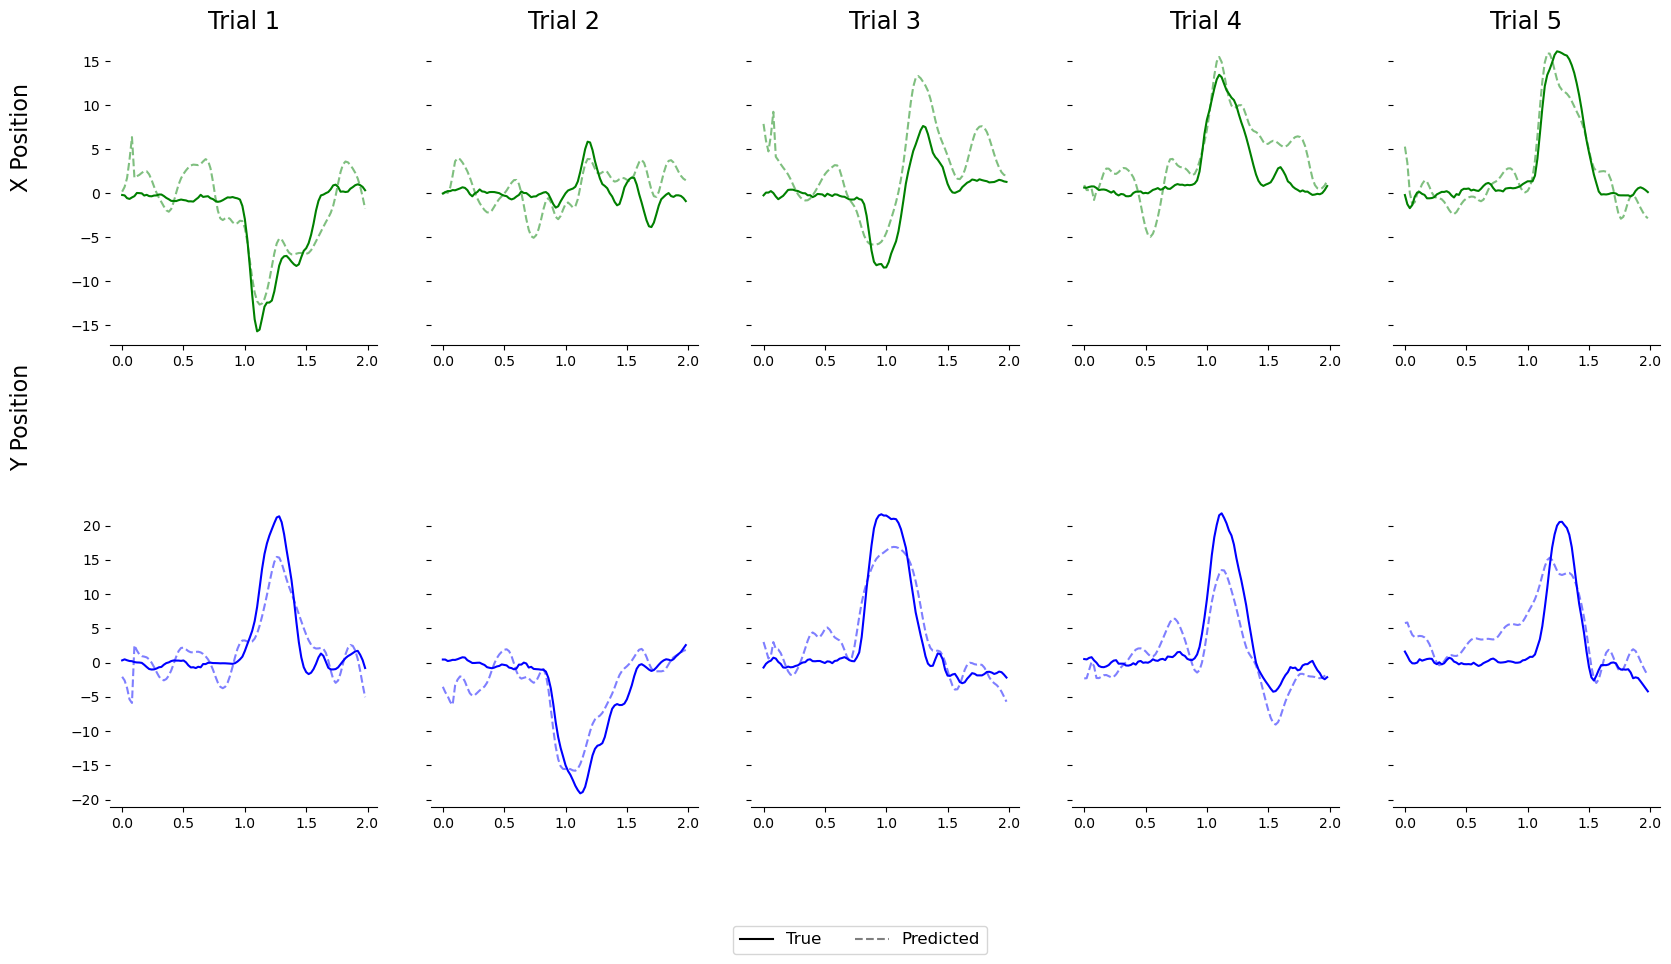

In [40]:
visualize_LSTM(y_pred_linear, y_val['fold'+str(fold)], seq_length = 100)

## Non-linear model

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

from src.trainer import *
from src.regularizers import *

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test,\
     info_train, info_val, info_test, mins, \
        maxs = train_test_split(baseline_df, train_variable = 'both_rates',\
        target_variable = 'vel', num_folds = 5)

In [43]:
adaptation_df = tidy_df.loc[tidy_df['epoch'] == 'AD']

In [44]:
X_train_ad, y_train_ad, X_val_ad, y_val_ad, X_test_ad, y_test_ad,\
     info_train_ad, info_val_ad, info_test_ad, mins_ad, \
        maxs_ad = train_test_split(adaptation_df, train_variable = 'both_rates',\
        target_variable = 'vel', num_folds = 5)

In [45]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 100

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [46]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 300
num_layers = 1
#input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

In [47]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [48]:
model_RNN = Causal_Simple_RNN(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    out_dims = num_dim_output, 
                    dropout = dropout ).to(device)

model_LSTM = Causal_Simple_LSTM(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    out_dims = num_dim_output, 
                    dropout = dropout ).to(device)

In [49]:
train_losses, val_losses = \
    train_model(model_RNN, xx_train,yy_train, #change by rnn
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer = regularizer,
                layer_type='rnn', #change by rnn
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                )

Epoch 000 Train 12.0972 Val 11.3627
Epoch 001 Train 9.9718 Val 9.8238
Epoch 002 Train 8.8460 Val 9.1384
Epoch 003 Train 8.1872 Val 8.6440
Epoch 004 Train 7.6402 Val 8.0713
Epoch 005 Train 6.8753 Val 7.0258
Epoch 006 Train 6.1098 Val 6.4187
Epoch 007 Train 5.6070 Val 6.0218
Epoch 008 Train 5.2063 Val 5.6210
Epoch 009 Train 4.8586 Val 5.2679
Epoch 010 Train 4.5062 Val 4.8531
Epoch 011 Train 4.1500 Val 4.5150
Epoch 012 Train 3.8449 Val 4.2324
Epoch 013 Train 3.5908 Val 4.0047
Epoch 014 Train 3.3808 Val 3.8330
Epoch 015 Train 3.2018 Val 3.6635
Epoch 016 Train 3.0568 Val 3.5435
Epoch 017 Train 2.9369 Val 3.4370
Epoch 018 Train 2.8375 Val 3.3919
Epoch 019 Train 2.7634 Val 3.3375
Epoch 020 Train 2.6817 Val 3.2661
Epoch 021 Train 2.6224 Val 3.1827
Epoch 022 Train 2.5603 Val 3.1510
Epoch 023 Train 2.5148 Val 3.1809
Epoch 024 Train 2.4907 Val 3.1581
Epoch 025 Train 2.4594 Val 3.0795
Epoch 026 Train 2.4300 Val 3.0985
Epoch 027 Train 2.4123 Val 3.0030
Epoch 028 Train 2.3884 Val 3.0238
Epoch 029 Tr

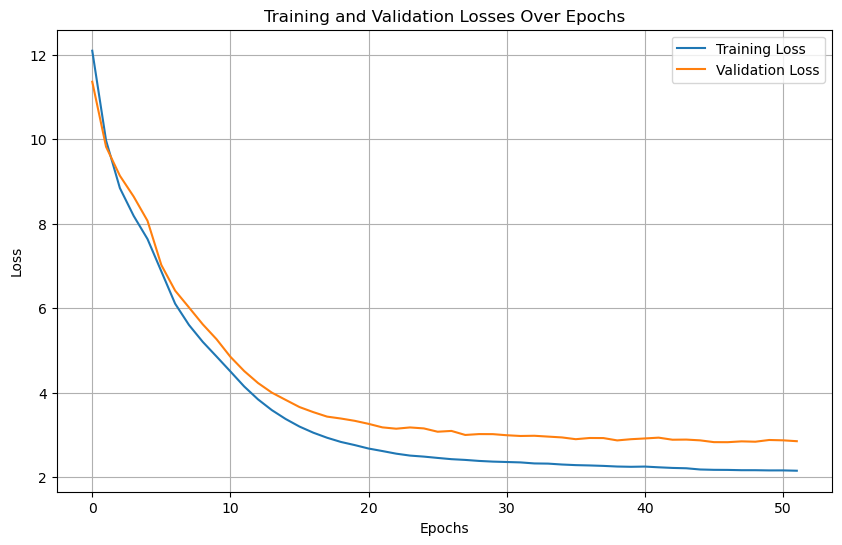

In [50]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [51]:
def reshape_to_eval(x,y, model_of_choice):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model_of_choice(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_of_choice, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model_of_choice)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model_of_choice)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model_of_choice)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_test, y_true_test,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

In [52]:
inputs = torch.tensor(xx_val, device=device, dtype=torch.float32)
targets = torch.tensor(yy_val, device=device, dtype=torch.float32)

In [53]:
y_array = targets.detach().cpu().numpy()

In [54]:
y_true_2D = y_array.reshape(-1, y_array.shape[-1])

In [55]:
path_to_models = '../Models/Baseline_Models_Force'
experiment_name_RNN = 'RNN_'+name+'_'+date
experiment_name_LSTM = 'LSTM_'+name+'_'+date
path_to_save_model_RNN = os.path.join(path_to_models,experiment_name_RNN)
path_to_save_model_LSTM = os.path.join(path_to_models,experiment_name_LSTM)

In [57]:
#torch.save(model_RNN, os.path.join(path_to_save_model_RNN,'fold_{}.pth'.format(fold))) 

In [134]:
#torch.save(model_LSTM, os.path.join(path_to_save_model_LSTM,'fold_{}.pth'.format(fold))) 

In [58]:
model_LSTM = torch.load(os.path.join(path_to_save_model_LSTM,'fold_{}.pth'.format(fold)))

In [59]:
model_RNN = torch.load(os.path.join(path_to_save_model_RNN,'fold_{}.pth'.format(fold)))

In [63]:
y_hat_RNN, y_true_RNN, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_RNN, metric = 'ev')

Train EV: 0.93 
Val EV: 0.89 
Test EV: 0.88 


In [64]:
y_hat_LSTM, y_true_LSTM, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_LSTM, metric = 'ev')

Train EV: 0.93 
Val EV: 0.89 
Test EV: 0.86 


In [77]:
def visualize_all_models(y_hat1, y_true1, y_hat2,
                        y_hat3, seq_length):
    """
    Visualize model predictions from multiple models (e.g., RNN, LSTM, Linear) versus true values for x and y velocities.

    Inputs:
        - y_hat1: Predicted values from the first model (e.g., RNN)
        - y_true1: True values to compare against
        - y_hat2: Predicted values from the second model (e.g., LSTM)
        - y_hat3: Predicted values from the third model (e.g., Linear)
        - seq_length: Length of the sequence used in the models

    Returns:
        - A set of plots comparing predicted and true values for multiple models across several trials
    """


    custom_palette = [
    '#DA70D6',  # orchid
    '#4682B4', #steel blue
    #'#5F9EA0', # cadet blue
    '#FFD700', # gold
    '#FFA07A', # light salmon
    '#87CEEB', # light blue
    '#9370DB', # medium purple
    '#98FB98'  # pale green
    ]

    custom_palette = [
    '#C44E52', # (a muted red)
    '#55A868', #(a muted green)
    '#64B5CD', #(a muted cyan)#'#4C72B0', #(a muted blue)
    '#8172B2', #(a muted purple)
    '#CCB974', #(a muted yellow-brown)
    '#64B5CD', #(a muted cyan)
    ]
    y_hat1 = y_hat1.reshape(y_hat1.shape[0] // seq_length, seq_length, y_hat1.shape[1])  
    y_true1 = y_true1.reshape(y_true1.shape[0] // seq_length, seq_length, y_true1.shape[1])  
    y_hat2 = y_hat2.reshape(y_hat2.shape[0] // seq_length, seq_length, y_hat2.shape[1])      
    y_hat3 = y_hat3.reshape(y_hat3.shape[0] // seq_length, seq_length, y_hat3.shape[1])  
    
    num_trials = y_hat1.shape[0]
    # Define time vector (assuming each sample represents 20ms)
    trial_len = y_true1.shape[1]
    time_vector = np.arange(0, trial_len * 0.02, 0.02)  # Time vector in seconds

    # Create a figure and axis objects
    fig, ax = plt.subplots(nrows=2, ncols=5, sharey='row', figsize=[10, 5])

    # Plot the signals with vertical spacing
    spacing = 0.5  # Adjust the spacing value as desired

    # Define a list of colors
    colors = custom_palette #['b', 'green', 'orange']

    alpha_predicted = 1
    linewidth_true = 1.5
    linewidth_pred = 2

    # Plot each variable (x, y, z) in separate rows
    for j in range(num_trials)[:5]:
        data1 = y_true1[j]
        pred_data1 = y_hat1[j]

        pred_data2 = y_hat2[j]

        pred_data3 = y_hat3[j]
        
        # Plot x variable
        ax[0, j].plot(time_vector, data1[:, 0], linewidth = linewidth_true, c='k', label='True')
        ax[0, j].plot(time_vector, pred_data3[:, 0], linewidth = linewidth_pred, c=colors[2], alpha=alpha_predicted, linestyle='--', label='Predicted Linear')
        ax[0, j].plot(time_vector, pred_data1[:, 0], linewidth = linewidth_true, c=colors[0], alpha=alpha_predicted, linestyle='--', label='Predicted RNN')
        ax[0, j].plot(time_vector, pred_data2[:, 0], linewidth = linewidth_pred, c=colors[1], alpha=alpha_predicted, linestyle='--', label='Predicted LSTM')        
        ax[0, j].set_title('Trial {}'.format(j+1), fontsize='x-large')
        ax[0, j].spines[['right', 'top', 'left']].set_visible(False)
        
        # Plot y variable
        ax[1, j].plot(time_vector, data1[:, 1], linewidth = linewidth_true, c='k', label='True')
        ax[1, j].plot(time_vector, pred_data3[:, 1], linewidth = linewidth_pred, c=colors[2], alpha=alpha_predicted, linestyle='--', label='Predicted Linear')
        ax[1, j].plot(time_vector, pred_data1[:, 1], linewidth = linewidth_true, c=colors[0], alpha=alpha_predicted, linestyle='--', label='Predicted RNN')
        ax[1, j].plot(time_vector, pred_data2[:, 1], linewidth = linewidth_pred, c=colors[1], alpha=alpha_predicted, linestyle='--', label='Predicted LSTM')
        ax[1, j].spines[['right', 'top', 'left']].set_visible(False)
        ax[1, j].set_xlabel("Time (s)")#, fontsize = 20)  

    # Set y-label only for the first column
    fig.text(0.075, 0.7, 'X Velocity', va='center', rotation='vertical')#, fontsize = 25)
    fig.text(0.075, 0.3, 'Y Velocity', va='center', rotation='vertical')#, fontsize = 25)

    # Create a common legend for all subplots
    handles, labels = ax[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2, fontsize='large')

    plt.subplots_adjust(hspace=0.5)

    # Show the plot
    plt.show()

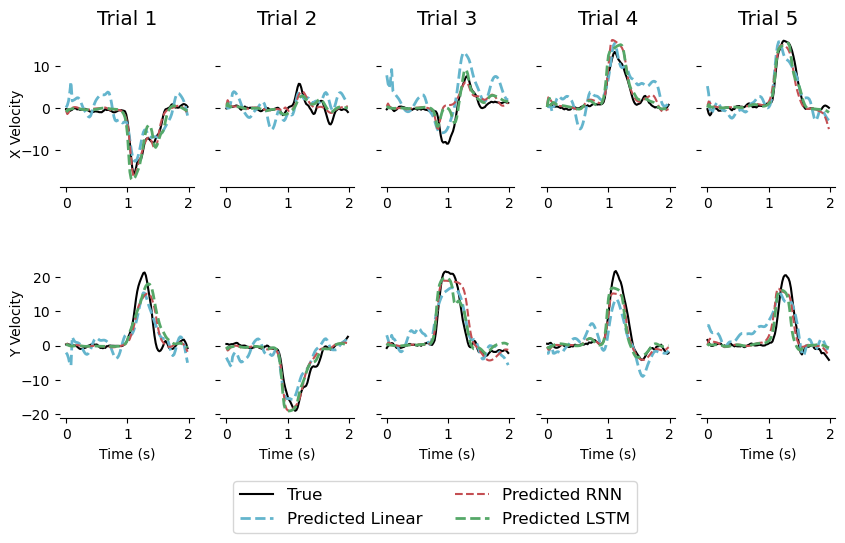

In [78]:
visualize_all_models(y_hat_RNN, y_true_RNN, \
                        y_hat_LSTM, 
                            y_pred_linear,   seq_length = 100)